In [1]:
!pip install mne --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 70.8 MB/s eta 0:00:00


In [5]:
import os
import zipfile
import warnings
from glob import glob
from pathlib import Path
import mne
import numpy as np
from mne.channels import make_standard_montage
from collections import Counter # Import Counter for robust event counting

# ===============================
# CONFIG
# ===============================
# These variables should match your environment
zip_path = '/content/drive/MyDrive/physionet_mi_full.zip'
extract_dir = '/content/local_data'
# Directory to save individual subject files
SAVE_DIR = Path('./preprocessed_mi_data_subjects')

# Standard parameters
COMMON_SFREQ = 128.0
HIGH_PASS = 4.0        # High-pass filter frequency in Hz
LOW_PASS = 38.0        # Low-pass filter frequency in Hz
TOTAL_SUBJECTS = 109

# Define the 3 original PhysioNet event IDs
EVENT_ID = {
    'T0': 1, # Rest (after MI cue ends) - Used for baseline correction only
    'T1': 2, # Movement/Imagery (Left Fist or Both Fists)
    'T2': 3  # Movement/Imagery (Right Fist or Both Feet)
}

# --- TARGET 4 MI CLASSES (User-defined control actions) ---
# All classes are derived from active Motor Imagery/Movement (T1/T2) events.
TARGET_EVENT_ID = {
    'Stop': 1,       # Control: Both Feet (T2 in Runs 9/10)
    'Left': 2,       # Control: Left Hand/Fist (T1 in Runs 7/8)
    'Right': 3,      # Control: Right Hand/Fist (T2 in Runs 7/8)
    'Forward': 4     # Control: Both Fists (T1 in Runs 9/10)
}

# Define which runs correspond to which task type
UNILATERAL_RUNS = [7, 8] # T1: Left Fist, T2: Right Fist
BILATERAL_RUNS = [9, 10] # T1: Both Fists, T2: Both Feet

# Define run-specific event IDs for use in mne.Epochs.
# This is crucial because each run only contains a subset of the 4 target classes.
UNILATERAL_EVENT_MAP = {
    'Left': TARGET_EVENT_ID['Left'],     # 2
    'Right': TARGET_EVENT_ID['Right']    # 3
}
BILATERAL_EVENT_MAP = {
    'Stop': TARGET_EVENT_ID['Stop'],     # 1
    'Forward': TARGET_EVENT_ID['Forward']# 4
}


# --- EPOCHING STRATEGY: 4-SECOND WINDOWS FOR ALL CLASSES ---
# All classes must have the same length and time window (active MI period: 0.0 to 4.0s)
EPOCH_TIMES = {
    TARGET_EVENT_ID['Stop']:    (0.0, 4.0),   # 4-second active MI period (Both Feet)
    TARGET_EVENT_ID['Left']:    (0.0, 4.0),   # 4-second active MI period (Left Fist)
    TARGET_EVENT_ID['Right']:   (0.0, 4.0),   # 4-second active MI period (Right Fist)
    TARGET_EVENT_ID['Forward']: (0.0, 4.0)    # 4-second active MI period (Both Fists)
}
T_MIN, T_MAX = EPOCH_TIMES[TARGET_EVENT_ID['Left']] # (0.0, 4.0)

# ===============================
# HELPER FUNCTIONS
# ===============================
def clean_physionet_channel_names(raw):
    """
    Renames PhysioNet channel names (e.g., 'Fc5.', 'C5..') to match MNE standard
    nomenclature (e.g., 'FC5', 'C5').
    """
    mapping = {}
    for ch_name in raw.ch_names:
        new_name = ch_name.rstrip('.')
        new_name = new_name.upper()
        mapping[ch_name] = new_name
    raw.rename_channels(mapping)
    return raw

# ===============================
# STEP 1 — Setup
# ===============================
extract_dir = Path(extract_dir)
if not extract_dir.exists():
    print("Extracting ZIP file... this may take a few minutes.")
    extract_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)
    print("Extraction complete.")
else:
    print("ZIP already extracted. Skipping extraction.")

SAVE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving preprocessed subject epochs to: {SAVE_DIR.resolve()}")

# ===============================
# MAIN PROCESSING LOOP
# ===============================
base_data_path = Path('/content/local_data/MNE-eegbci-data/files/eegmmidb/1.0.0')
# Set log level to WARNING to clearly see dropped epoch messages
mne.set_log_level('WARNING')

REQUIRED_RUNS = UNILATERAL_RUNS + BILATERAL_RUNS
REQUIRED_RUNS_SET = set(REQUIRED_RUNS)

for i in range(1, TOTAL_SUBJECTS + 1):
    subject_name = f'S{i:03d}'
    subject_folder = base_data_path / subject_name

    if not subject_folder.exists():
        print(f"\n--- Skipping {subject_name}: Data folder not found. ---")
        continue

    run_files = sorted(glob(str(subject_folder / f"{subject_name}R*.edf")))
    filtered_run_files = []
    for file_path in run_files:
        run_number_str = os.path.basename(file_path).split('R')[1].split('.edf')[0]
        try:
            run_number = int(run_number_str)
            if run_number in REQUIRED_RUNS_SET:
                filtered_run_files.append(file_path)
        except ValueError:
            continue

    print(f"\n==============================================")
    print(f"=== Processing Subject {subject_name} (S{i}) ===")
    print(f"==============================================")

    if len(filtered_run_files) == 0:
        print(f"No required runs found for {subject_name}. Skipping.")
        continue

    subject_epochs_list = []

    # ===============================
    # Load, Preprocess, and Epoch each run
    # ===============================
    for file_path in filtered_run_files:
        run_number_str = os.path.basename(file_path).split('R')[1].split('.edf')[0]
        run_number = int(run_number_str)
        print(f"\n--- Loading Run R{run_number} ---")

        try:
            # Load and preprocess
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

            raw = clean_physionet_channel_names(raw)

            montage = make_standard_montage('standard_1005')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                raw.set_montage(montage, on_missing='warn')

            picks = mne.pick_types(raw.info, eeg=True, eog=False, stim=False, exclude='bads')
            raw.pick(picks)

            if raw.info['sfreq'] != COMMON_SFREQ:
                raw.resample(COMMON_SFREQ)

            raw.filter(HIGH_PASS, LOW_PASS, fir_design='firwin')
            # Apply common average reference (CAR)
            raw.set_eeg_reference('average', projection=True).apply_proj()

            # --- 4. Event Extraction and Mapping (Revised for 4 MI Control Classes) ---
            events, _ = mne.events_from_annotations(raw, event_id=EVENT_ID, verbose=False)
            print(f"Raw events found: {len(events)}")

            final_mi_events = []
            run_event_id = None # Initialize run-specific event map

            if run_number in UNILATERAL_RUNS: # R7, R8: Left/Right Fists
                run_event_id = UNILATERAL_EVENT_MAP
            elif run_number in BILATERAL_RUNS: # R9, R10: Both Fists/Both Feet
                run_event_id = BILATERAL_EVENT_MAP
            else:
                print(f"WARNING: Run {run_number} is not a required MI run. Skipping.")
                continue


            for event_time, _, original_id in events:
                new_id = None

                # We only care about T1 (ID 2) and T2 (ID 3) events for the 4 control classes.
                if original_id == EVENT_ID['T0']:
                    continue

                if run_number in UNILATERAL_RUNS:
                    if original_id == EVENT_ID['T1']: # Left Fist
                        new_id = TARGET_EVENT_ID['Left']      # ID 2
                    elif original_id == EVENT_ID['T2']: # Right Fist
                        new_id = TARGET_EVENT_ID['Right']     # ID 3

                elif run_number in BILATERAL_RUNS:
                    if original_id == EVENT_ID['T1']: # Both Fists -> Forward
                        new_id = TARGET_EVENT_ID['Forward']   # ID 4
                    elif original_id == EVENT_ID['T2']: # Both Feet -> Stop
                        new_id = TARGET_EVENT_ID['Stop']      # ID 1

                if new_id is not None:
                    final_mi_events.append([event_time, 0, new_id])

            if not final_mi_events:
                print("WARNING: No target MI events found in this run. Skipping epoching for this run.")
                continue

            final_events_array = np.array(final_mi_events)

            # Use the run-specific event map for reporting
            run_class_names = "/".join(run_event_id.keys())
            print(f"Final target MI events ({run_class_names}): {len(final_events_array)}")

            # --- 5. Epoching (Single Call for Uniform Time Length) ---
            # All epochs use the 4-second active MI window [0.0, 4.0]

            # Note: Since the T0 rest period is excluded from the events array,
            # we apply no baseline correction here. You may apply it later
            # using the T0 data if needed, but for now, we process raw MI periods.
            epochs = mne.Epochs(
                raw,
                final_events_array,
                event_id=run_event_id, # <--- CRUCIAL CHANGE: Use the run-specific event map
                tmin=T_MIN,
                tmax=T_MAX,
                baseline=None,
                preload=True,
                reject_by_annotation=False,
                event_repeated='merge',
                verbose=False
            )

            # Epochs are dropped if they contain artifacts
            print(f"Initial Epochs (Full Window): {len(epochs)}")
            epochs.drop_bad()
            print(f"Initial Epochs (After Drop Bad): {len(epochs)}")

            if len(epochs) > 0:
                # Report class counts for clarity
                # FIX: Replaced epochs.get_event_counts() with a manual count
                # using the underlying events array and Counter, as get_event_counts
                # might be missing in some MNE versions.
                event_ids = epochs.events[:, 2] # Get the third column (event ID)
                id_counts = Counter(event_ids)

                counts = {}
                # Map IDs back to labels using the run-specific event_id dictionary
                id_to_label = {v: k for k, v in epochs.event_id.items()}

                for id_val, count in id_counts.items():
                    label = id_to_label.get(id_val, f"Unknown ID {id_val}")
                    counts[label] = count

                for label, count in counts.items():
                    print(f"  - Class '{label}' epochs created: {count}")

                subject_epochs_list.append(epochs)
                print(f"  - Run R{run_number} epochs: {len(epochs)}")
            else:
                print(f"  - Run R{run_number} had 0 valid epochs after drop_bad. Skipping.")

        except Exception as e:
            # We catch any other critical failure here
            print(f"--- FATAL ERROR processing R{run_number} for {subject_name}: {e} ---")
            continue


    # ===============================
    # Combine epochs for the subject and SAVE INDIVIDUALLY
    # ===============================
    if subject_epochs_list:
        print("\n--- Concatenating all runs for subject ---")
        try:
            # Since all individual run epochs were created in a single call with
            # the same tmin/tmax, they are guaranteed to concatenate successfully.
            subject_epochs = mne.concatenate_epochs(subject_epochs_list)

            # Save this subject's data individually
            save_path = SAVE_DIR / f"{subject_name}-epo.fif"

            # Save the epochs object
            subject_epochs.save(save_path, overwrite=True, verbose=False)
            print(f"*** SUCCESS: Subject {subject_name} Final Epochs: {len(subject_epochs)} (Saved to {save_path.name}) ***")

        except Exception as e:
            print(f"*** CRITICAL ERROR saving {subject_name}: {e} ***")
    else:
        print(f"--- No valid epochs generated for {subject_name} across all runs. Skipping save. ---")

# ===============================
# Final Output
# ===============================
print("\n====================================")
print(f"Preprocessing Complete! Individual subject files saved to: {SAVE_DIR.resolve()}")
print("====================================")

Extracting ZIP file... this may take a few minutes.
Extraction complete.
Saving preprocessed subject epochs to: /content/preprocessed_mi_data_subjects

=== Processing Subject S001 (S1) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI even

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S005 Final Epochs: 60 (Saved to S005-epo.fif) ***

=== Processing Subject S006 (S6) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dro

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S006 Final Epochs: 60 (Saved to S006-epo.fif) ***

=== Processing Subject S007 (S7) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dro

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S016 Final Epochs: 60 (Saved to S016-epo.fif) ***

=== Processing Subject S017 (S17) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S027 Final Epochs: 60 (Saved to S027-epo.fif) ***

=== Processing Subject S028 (S28) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 14

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 14

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S049 Final Epochs: 60 (Saved to S049-epo.fif) ***

=== Processing Subject S050 (S50) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S060 Final Epochs: 60 (Saved to S060-epo.fif) ***

=== Processing Subject S061 (S61) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S061 Final Epochs: 60 (Saved to S061-epo.fif) ***

=== Processing Subject S062 (S62) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 14

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 14

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S072 Final Epochs: 56 (Saved to S072-epo.fif) ***

=== Processing Subject S073 (S73) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 14

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 14

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 38
Final target MI events (Left/Right): 19
Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Right' epochs created: 9
  - Class 'Left' epochs created: 10
  - Run R7 epochs: 19

--- Loading Run R8 ---
Raw events found: 38
Final target MI events (Left/Right): 19
Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Left' epochs created: 10
  - Class 'Right' epochs created: 9
  - Run R8 epochs: 19

--- Loading Run R9 ---
Raw events found: 38
Final target MI events (Stop/Forward): 19
Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Forward' epochs created: 10
  - Class 'Stop' epochs created: 9
  - Run R9 epochs: 19

--- Loading Run R10 ---
Raw events found: 38
Final target MI events (Stop/Forward): 19
Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Forward' epochs created: 10
  - Class 'Stop' epochs created: 9
  - Run R10 epochs: 19

--- Concatenating all

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S088 Final Epochs: 76 (Saved to S088-epo.fif) ***

=== Processing Subject S089 (S89) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Left' epochs created: 10
  - Class 'Right' epochs created: 9
  - Run R7 epochs: 19

--- Loading Run R8 ---
Raw events found: 38
Final target MI events (Left/Right): 19
Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Left' epochs created: 9
  - Class 'Right' epochs created: 10
  - Run R8 epochs: 19

--- Loading Run R9 ---
Raw events found: 38
Final target MI events (Stop/Forward): 19
Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Forward' epochs created: 10
  - Class 'Stop' epochs created: 9
  - Run R9 epochs: 19

--- Loading Run R10 ---
Raw events found: 38
Final target MI events (Stop/Forward): 19
Initial Epochs (Full Window): 19
Initial Epochs (After Drop Bad): 19
  - Class 'Stop' epochs created: 9
  - Class 'Forward' epochs created: 10
  - Run R10 epochs: 19

--- Concatenating all runs for subject ---


/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S092 Final Epochs: 76 (Saved to S092-epo.fif) ***

=== Processing Subject S093 (S93) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Dr

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Initial Epochs (Full Window): 12
Initial Epochs (After Drop Bad): 12
  - Class 'Right' epochs created: 6
  - Class 'Left' epochs created: 6
  - Run R7 epochs: 12

--- Loading Run R8 ---
Raw events found: 24
Final target MI events (Left/Right): 12
Initial Epochs (Full Window): 12
Initial Epochs (After Drop Bad): 12
  - Class 'Right' epochs created: 6
  - Class 'Left' epochs created: 6
  - Run R8 epochs: 12

--- Loading Run R9 ---
Raw events found: 24
Final target MI events (Stop/Forward): 12
Initial Epochs (Full Window): 12
Initial Epochs (After Drop Bad): 12
  - Class 'Stop' epochs created: 6
  - Class 'Forward' epochs created: 6
  - Run R9 epochs: 12

--- Loading Run R10 ---
Raw events found: 24
Final target MI events (Stop/Forward): 12
Initial Epochs (Full Window): 12
Initial Epochs (After Drop Bad): 12
  - Class 'Stop' epochs created: 6
  - Class 'Forward' epochs created: 6
  - Run R10 epochs: 12

--- Concatenating all runs for subject ---


/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S100 Final Epochs: 48 (Saved to S100-epo.fif) ***

=== Processing Subject S101 (S101) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After D

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 14

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 14

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 14

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 14
Initial Epochs (After Drop Bad): 14
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 14

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 8
  - Class 'Right' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 26
Final target MI events (Left/Right): 13
Initial Epochs (Full Window): 12
Initial Epochs (After Drop Bad): 12
  - Class 'Left' epochs created: 6
  - Class 'Right' epochs created: 6
  - Run R8 epochs: 12

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Left' epochs created: 7
  - Class 'Right' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


*** SUCCESS: Subject S105 Final Epochs: 60 (Saved to S105-epo.fif) ***

=== Processing Subject S106 (S106) ===

--- Loading Run R7 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After D

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 7
  - Class 'Stop' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 8
  - Class 'Forward' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)


Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 8
  - Class 'Left' epochs created: 7
  - Run R7 epochs: 15

--- Loading Run R8 ---
Raw events found: 30
Final target MI events (Left/Right): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Right' epochs created: 7
  - Class 'Left' epochs created: 8
  - Run R8 epochs: 15

--- Loading Run R9 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Stop' epochs created: 7
  - Class 'Forward' epochs created: 8
  - Run R9 epochs: 15

--- Loading Run R10 ---
Raw events found: 30
Final target MI events (Stop/Forward): 15
Initial Epochs (Full Window): 15
Initial Epochs (After Drop Bad): 15
  - Class 'Forward' epochs created: 8
  - Class 'Stop' epochs created: 7
  - Run R10 epochs: 15

--- Concatenating all run

/tmp/ipython-input-1461671097.py:280: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  subject_epochs = mne.concatenate_epochs(subject_epochs_list)



[INFO] Loading data from 109 subject files in preprocessed_mi_data_subjects...
[INFO] Loaded 6521 total trials.
[INFO] Final 0-based label mapping: {0: 'Forward', 1: 'Left', 2: 'Right', 3: 'Stop'}

[INFO] Starting 5-Fold Cross-Validation on 4 classes...

--- FOLD 1/5 ---
  Using device: cuda
  [INFO] Feature extractor output sequence length: 32
  Epoch 10/100, Average Loss: 1.3262
  Epoch 20/100, Average Loss: 0.8968
  Epoch 30/100, Average Loss: 0.6028
  Epoch 40/100, Average Loss: 0.4441
  Epoch 50/100, Average Loss: 0.3874
  Epoch 60/100, Average Loss: 0.3244
  Epoch 70/100, Average Loss: 0.2647
  Epoch 80/100, Average Loss: 0.2241
  Epoch 90/100, Average Loss: 0.2241
  Epoch 100/100, Average Loss: 0.2059
  Fold 1 Test Accuracy: 48.89%
  Confusion Matrix:
[[106  49  55 122]
 [ 25 200  60  64]
 [ 21  52 175  54]
 [ 32  74  59 157]]


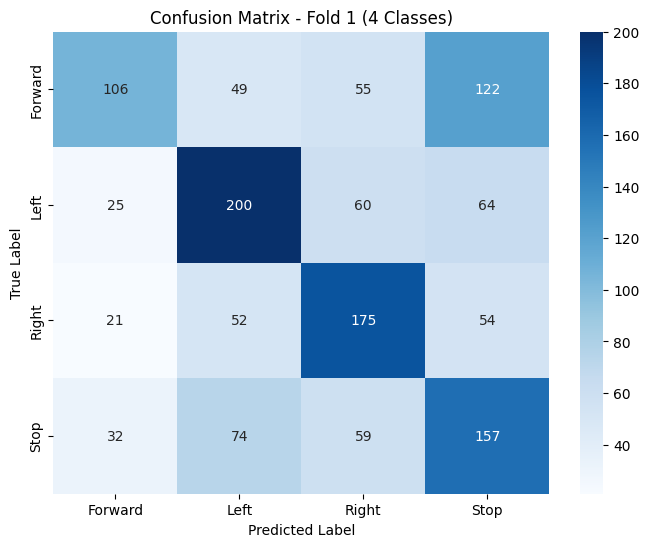


--- FOLD 2/5 ---
  Using device: cuda
  [INFO] Feature extractor output sequence length: 32
  Epoch 10/100, Average Loss: 1.2683
  Epoch 20/100, Average Loss: 0.8685
  Epoch 30/100, Average Loss: 0.6278
  Epoch 40/100, Average Loss: 0.4744
  Epoch 50/100, Average Loss: 0.4257
  Epoch 60/100, Average Loss: 0.3324
  Epoch 70/100, Average Loss: 0.2861
  Epoch 80/100, Average Loss: 0.2418
  Epoch 90/100, Average Loss: 0.2226
  Epoch 100/100, Average Loss: 0.2338
  Fold 2 Test Accuracy: 48.31%
  Confusion Matrix:
[[128  54  44  85]
 [ 46 150  44  70]
 [ 38  45 202  66]
 [ 66  61  55 150]]


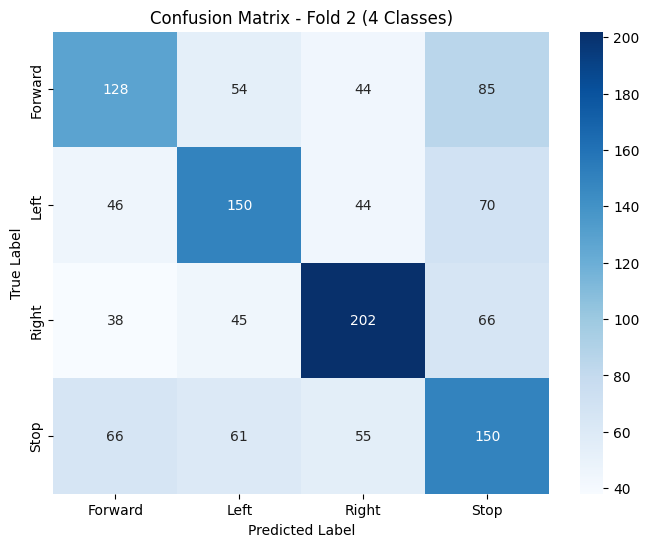


--- FOLD 3/5 ---
  Using device: cuda
  [INFO] Feature extractor output sequence length: 32
  Epoch 10/100, Average Loss: 1.3263
  Epoch 20/100, Average Loss: 0.9494
  Epoch 30/100, Average Loss: 0.6640
  Epoch 40/100, Average Loss: 0.5603
  Epoch 50/100, Average Loss: 0.4054
  Epoch 60/100, Average Loss: 0.3520
  Epoch 70/100, Average Loss: 0.3109
  Epoch 80/100, Average Loss: 0.2831
  Epoch 90/100, Average Loss: 0.2790
  Epoch 100/100, Average Loss: 0.2499
  Fold 3 Test Accuracy: 47.55%
  Confusion Matrix:
[[116  69  45  86]
 [ 36 184  29  70]
 [ 39  65 160  63]
 [ 44  96  42 160]]


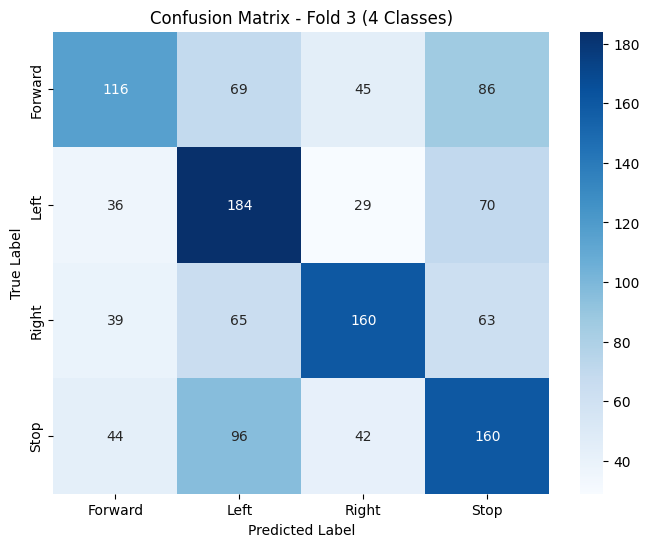


--- FOLD 4/5 ---
  Using device: cuda
  [INFO] Feature extractor output sequence length: 32
  Epoch 10/100, Average Loss: 1.3549
  Epoch 20/100, Average Loss: 0.9019
  Epoch 30/100, Average Loss: 0.6154
  Epoch 40/100, Average Loss: 0.4902
  Epoch 50/100, Average Loss: 0.4040
  Epoch 60/100, Average Loss: 0.3372
  Epoch 70/100, Average Loss: 0.2974
  Epoch 80/100, Average Loss: 0.2802
  Epoch 90/100, Average Loss: 0.2605
  Epoch 100/100, Average Loss: 0.2500
  Fold 4 Test Accuracy: 49.46%
  Confusion Matrix:
[[147  51  65  88]
 [ 35 174  49  88]
 [ 40  36 187  52]
 [ 50  51  54 137]]


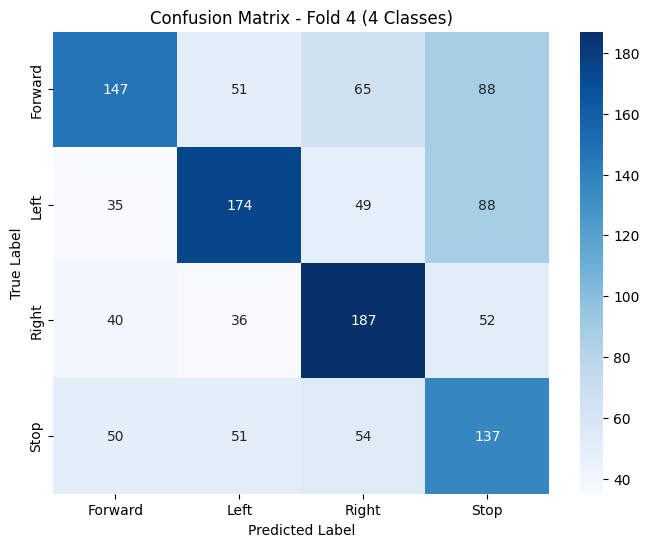


--- FOLD 5/5 ---
  Using device: cuda
  [INFO] Feature extractor output sequence length: 32
  Epoch 10/100, Average Loss: 1.2887
  Epoch 20/100, Average Loss: 0.8813
  Epoch 30/100, Average Loss: 0.6276
  Epoch 40/100, Average Loss: 0.4819
  Epoch 50/100, Average Loss: 0.4171
  Epoch 60/100, Average Loss: 0.3967
  Epoch 70/100, Average Loss: 0.3507
  Epoch 80/100, Average Loss: 0.2944
  Epoch 90/100, Average Loss: 0.2557
  Epoch 100/100, Average Loss: 0.2654
  Fold 5 Test Accuracy: 48.31%
  Confusion Matrix:
[[141  77  64  42]
 [ 47 204  43  22]
 [ 44  56 197  27]
 [ 77 105  70  88]]


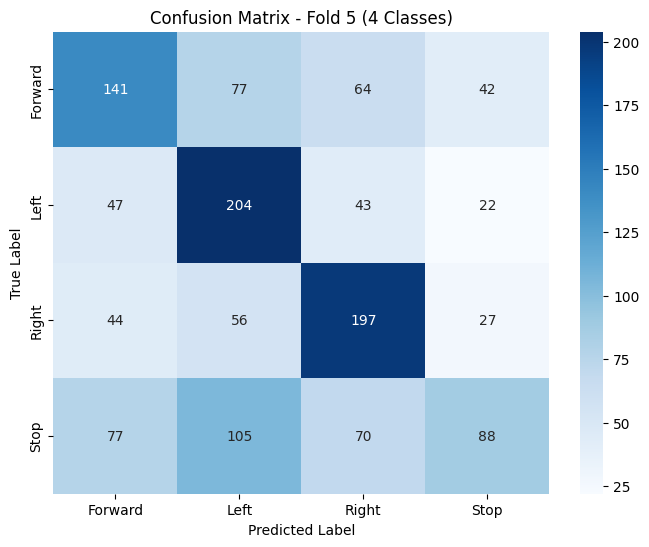


FINAL 5-FOLD CV RESULTS
Mean Test Accuracy: 48.50% (Std: 0.64%)


--- FINAL MODEL TRAINING ON FULL DATASET ---
  Using device: cuda
  [INFO] Feature extractor output sequence length: 32
  Final Model - Epoch 10/100, Average Loss: 1.3203
  Final Model - Epoch 20/100, Average Loss: 0.9151
  Final Model - Epoch 30/100, Average Loss: 0.6495
  Final Model - Epoch 40/100, Average Loss: 0.4962
  Final Model - Epoch 50/100, Average Loss: 0.4086
  Final Model - Epoch 60/100, Average Loss: 0.3470
  Final Model - Epoch 70/100, Average Loss: 0.2912
  Final Model - Epoch 80/100, Average Loss: 0.2717
  Final Model - Epoch 90/100, Average Loss: 0.2591
  Final Model - Epoch 100/100, Average Loss: 0.2546

[SUCCESS] Final model weights saved to: mirapnet_final_model.pth

[SUCCESS] Final full model saved to: mirapnet_final_model_full.pth


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import mne
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

# Suppress minor warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning)

# --- CONFIGURATION ---
DATA_DIR = './preprocessed_mi_data_subjects'
N_CHANNELS = 64
SFREQ = 128.0
# The largest window is 4.0s (Left/Right/Forward)
MAX_TIME_DURATION = 4.0
N_TIMESTEPS = int(MAX_TIME_DURATION * SFREQ) # 512
N_CLASSES = 4 # Stop, Left, Right, Forward
BATCH_SIZE = 32
N_EPOCHS = 100
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-4 # ADDED: L2 regularization was missing here
MODEL_SAVE_PATH = 'mirapnet_final_model.pth' # ADDED: Path to save the final model

# --- 1. MIRepNet ARCHITECTURE (PyTorch Implementation) ---

class SpatioTemporalFeatureExtractor(nn.Module):
    """
    CNN-based Spatio-Temporal Feature Extractor (Part of MIRepNet)
    """
    def __init__(self, in_channels=N_CHANNELS, time_steps=N_TIMESTEPS, embed_dim=128):
        super(SpatioTemporalFeatureExtractor, self).__init__()

        # 1. Spatial Convolution (Focus on channels)
        # Input: (B, 64, N_TIMESTEPS=512)
        self.spatial_conv = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # 2. Temporal Convolution (Feature learning over time)
        # Input: (B, 64, 512)
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=32, stride=8, padding=16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2),

            nn.Conv1d(64, embed_dim, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

    def forward(self, x):
        # x shape: (B, C, T) -> (B, 64, 512)
        x = self.spatial_conv(x)
        x = self.temporal_conv(x)
        # Output shape: (B, embed_dim, seq_len)
        return x

class MIRepNet(nn.Module):
    """
    The full MIRepNet model, combining CNN feature extraction and Transformer Encoder.
    """
    def __init__(self, in_channels=N_CHANNELS, time_steps=N_TIMESTEPS, embed_dim=128, num_heads=8, num_layers=2, num_classes=N_CLASSES):
        super(MIRepNet, self).__init__()

        # 1. Feature Extractor (CNN)
        self.feature_extractor = SpatioTemporalFeatureExtractor(
            in_channels=in_channels,
            time_steps=time_steps,
            embed_dim=embed_dim
        )

        # 2. Determine sequence length dynamically for Positional Encoding/Transformer
        with torch.no_grad():
            dummy_input = torch.randn(1, in_channels, time_steps)
            dummy_output = self.feature_extractor(dummy_input)
            self.seq_len = dummy_output.shape[2]
            print(f"  [INFO] Feature extractor output sequence length: {self.seq_len}")

        # 3. Transformer Encoder (Temporal Modeling)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.3,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # 4. Classification Head
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        # Transpose for Transformer: (B, C, L) -> (B, L, C)
        x = x.transpose(1, 2)
        x = self.transformer_encoder(x)
        # Transpose back for pooling: (B, L, C) -> (B, C, L)
        x = x.transpose(1, 2)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

# --- 2. DATA LOADING AND PREPARATION (MODIFIED FOR PADDING) ---

def load_data(data_dir):
    """Loads all individual MNE epochs files, pads shorter epochs, and concatenates them."""

    data_dir = Path(data_dir)
    fif_files = sorted(glob(str(data_dir / "S*-epo.fif")))

    if not fif_files:
        print(f"[ERROR] No MNE epochs files found in {data_dir}. Ensure 'preprocess_eeg_data.py' ran successfully.")
        return None, None, None

    print(f"\n[INFO] Loading data from {len(fif_files)} subject files in {data_dir}...")

    all_X_data = []
    all_y_data = []

    # Load the first file to get the correct event mapping and structure
    try:
        first_epochs = mne.read_epochs(fif_files[0], preload=True, verbose=False)
        # Determine the maximum required number of time points
        max_n_times = N_TIMESTEPS # 512

        # Get the MNE ID to 0-based index mapping
        unique_ids = sorted(first_epochs.event_id.values())
        id_to_index = {id_val: index for index, id_val in enumerate(unique_ids)}
        index_to_label = {index: label for index, label in enumerate(sorted(first_epochs.event_id.keys()))}
        # The final mapping is from sorted event labels: {0: 'Forward', 1: 'Left', 2: 'Right', 3: 'Stop'} (or similar)

    except Exception as e:
        print(f"[ERROR] Could not load the first epochs file for configuration. Details: {e}")
        return None, None, None


    # Load all subject files iteratively
    for i, file_path in enumerate(fif_files):
        try:
            epochs = mne.read_epochs(file_path, preload=True, verbose=False)
            X = epochs.get_data(copy=False)
            y_raw = epochs.events[:, -1]

            # --- PADDING LOGIC (CRITICAL FOR MIXED TIME WINDOWS) ---
            X_padded = []
            for trial_data in X:
                current_n_times = trial_data.shape[1]
                if current_n_times < max_n_times:
                    # Pad with zeros to match the longest epoch length (512)
                    padding_width = max_n_times - current_n_times
                    # Pad on the right (time axis, axis=1)
                    # ((channels_before, channels_after), (time_before, time_after))
                    padded_trial = np.pad(trial_data, ((0, 0), (0, padding_width)), mode='constant')
                    X_padded.append(padded_trial)
                else:
                    X_padded.append(trial_data)

            X_padded = np.stack(X_padded, axis=0)

            # Map MNE event IDs to 0-based PyTorch indices
            y = np.array([id_to_index[id_val] for id_val in y_raw])

            all_X_data.append(X_padded)
            all_y_data.append(y)

        except Exception as e:
            print(f"[WARNING] Skipping file {Path(file_path).name} due to loading error: {e}")
            continue

    # Concatenate all data into large numpy arrays
    X_full = np.concatenate(all_X_data, axis=0)
    y_full = np.concatenate(all_y_data, axis=0)

    print(f"[INFO] Loaded {X_full.shape[0]} total trials.")
    print(f"[INFO] Final 0-based label mapping: {index_to_label}")

    # Convert to PyTorch Tensors
    X_tensor = torch.from_numpy(X_full).float()
    y_tensor = torch.from_numpy(y_full).long()

    return X_tensor, y_tensor, index_to_label

# --- 3. TRAINING AND TESTING PIPELINE ---

def plot_confusion_matrix(cm, class_labels, fold):
    """Plots and saves the confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - Fold {fold} (4 Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.close() # Close plot to prevent memory issues

# ADDED: New function for training the final model on all data
def train_final_model(X_full, y_full, model_save_path):
    """Trains the final model on the entire dataset and saves it."""
    print("\n\n--- FINAL MODEL TRAINING ON FULL DATASET ---")

    final_dataset = TensorDataset(X_full, y_full)
    final_loader = DataLoader(final_dataset, batch_size=BATCH_SIZE, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"  Using device: {device}")

    model = MIRepNet(num_classes=N_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

    # Training Loop
    model.train()
    for epoch in range(N_EPOCHS):
        total_loss = 0
        for X_batch, y_batch in final_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()

        if (epoch + 1) % 10 == 0 or epoch == N_EPOCHS:
            print(f"  Final Model - Epoch {epoch+1}/{N_EPOCHS}, Average Loss: {total_loss / len(final_loader):.4f}")

    # Save the final model's weights (original)
    torch.save(model.state_dict(), model_save_path)
    print(f"\n[SUCCESS] Final model weights saved to: {model_save_path}")

    # --- NEW: Save full model (architecture + weights) ---
    torch.save(model, model_save_path.replace('.pth', '_full.pth'))
    print(f"\n[SUCCESS] Final full model saved to: {model_save_path.replace('.pth', '_full.pth')}")

def fine_tune_and_test(X, y, index_to_label):
    """Runs the K-Fold cross-validation fine-tuning and testing pipeline."""

    if X is None or y is None:
        print("Aborting training due to data loading error.")
        return

    class_labels = [index_to_label[i] for i in sorted(index_to_label.keys())]

    # K-Fold Setup (e.g., 5-fold cross-validation)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies = []

    print(f"\n[INFO] Starting {n_splits}-Fold Cross-Validation on {N_CLASSES} classes...")

    # The CV loop remains as it was, providing performance metrics
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\n--- FOLD {fold+1}/{n_splits} ---")

        # 1. Split Data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # 2. Model, Loss, and Optimizer
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"  Using device: {device}")

        # Re-initialize the model for each fold
        model = MIRepNet(num_classes=N_CLASSES).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

        # 3. Training Loop (Fine-Tuning)
        model.train()
        for epoch in range(N_EPOCHS):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Step the scheduler after each epoch
            scheduler.step()

            if (epoch + 1) % 10 == 0 or epoch == N_EPOCHS:
                print(f"  Epoch {epoch+1}/{N_EPOCHS}, Average Loss: {total_loss / len(train_loader):.4f}")

        # 4. Testing Loop
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        # 5. Evaluation Metrics
        accuracy = accuracy_score(all_labels, all_preds)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        print(f"  Fold {fold+1} Test Accuracy: {accuracy*100:.2f}%")
        print("  Confusion Matrix:")
        print(conf_matrix)

        plot_confusion_matrix(conf_matrix, class_labels, fold + 1)

        fold_accuracies.append(accuracy)

    # 6. Final CV Results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)

    print("\n=============================================")
    print(f"FINAL {n_splits}-FOLD CV RESULTS")
    print(f"Mean Test Accuracy: {mean_accuracy*100:.2f}% (Std: {std_accuracy*100:.2f}%)")
    print("=============================================")

    # ADDED: Train final model after CV is complete
    train_final_model(X, y, MODEL_SAVE_PATH)


# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # Load and prepare data
    X, y, index_to_label = load_data(DATA_DIR)

    # Run the fine-tuning and testing pipeline (now includes final model saving)
    if X is not None and y is not None:
        fine_tune_and_test(X, y, index_to_label)

In [33]:
import torch
import numpy as np
import mne
from pathlib import Path

# ===============================
# 1. Configuration
# ===============================
DATA_DIR = Path('./preprocessed_mi_data_subjects')
MODEL_WEIGHTS_PATH = '/content/mirapnet_final_model.pth'  # weights-only
N_CHANNELS = 64
SFREQ = 128.0
N_TIMESTEPS = 513  # your sample has 513 points
N_CLASSES = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# 2. Define the MIRepNet model
# ===============================
import torch.nn as nn

class SpatioTemporalFeatureExtractor(nn.Module):
    def __init__(self, in_channels=N_CHANNELS, time_steps=N_TIMESTEPS, embed_dim=128):
        super().__init__()
        self.spatial_conv = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=32, stride=8, padding=16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2),
            nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
    def forward(self, x):
        x = self.spatial_conv(x)
        x = self.temporal_conv(x)
        return x

class MIRepNet(nn.Module):
    def __init__(self, in_channels=N_CHANNELS, time_steps=N_TIMESTEPS, embed_dim=128, num_heads=8, num_layers=2, num_classes=N_CLASSES):
        super().__init__()
        self.feature_extractor = SpatioTemporalFeatureExtractor(in_channels, time_steps, embed_dim)
        # Determine sequence length for transformer
        with torch.no_grad():
            dummy_input = torch.randn(1, in_channels, time_steps)
            dummy_output = self.feature_extractor(dummy_input)
            self.seq_len = dummy_output.shape[2]
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            dropout=0.3,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim//2),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(embed_dim//2, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)       # (B, C, L)
        x = x.transpose(1,2)                # (B, L, C)
        x = self.transformer_encoder(x)     # (B, L, C)
        x = x.transpose(1,2)                # (B, C, L)
        x = self.global_pool(x)             # (B, C, 1)
        x = self.classifier(x)
        return x

# ===============================
# 3. Load weights into the model
# ===============================
model = MIRepNet().to(device)
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))
model.eval()
print("[INFO] Model loaded with weights.")

# ===============================
# 4. Load a sample epoch
# ===============================
sample_file = list(DATA_DIR.glob('*-epo.fif'))[0]
print("Using sample file:", sample_file.name)
epochs = mne.read_epochs(sample_file, preload=True, verbose=False)
data = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
print("Original epochs shape:", data.shape)

# Pick one random epoch
sample_epoch = data[np.random.randint(data.shape[0])]
sample_input = torch.tensor(sample_epoch, dtype=torch.float32).unsqueeze(0).to(device)
sample_label = epochs.events[np.random.randint(len(epochs.events)), 2]
print("Sample true label:", sample_label)

# ===============================
# 5. Run inference
# ===============================
with torch.no_grad():
    output = model(sample_input)
    predicted_class = output.argmax(dim=1).item()

print("Predicted class:", predicted_class)


[INFO] Model loaded with weights.
Using sample file: S078-epo.fif
Original epochs shape: (60, 64, 513)
Sample true label: 3
Predicted class: 3
